## 市場均衡価格とEndogeneity bias

In [1]:
## import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns

## seed
np.random.seed(42)

### Datasetの作成

In [2]:
class DataGenerator:
    def __init__(self,
                 beta_d=-0.5, 
                 beta_s=0.3, 
                 alpha_d=10, 
                 alpha_s=8,
                 sigma_d=0.8,
                 sigma_s=0.5,
                 t=1000):
        # initialize
        self.beta_d  = beta_d
        self.beta_s  = beta_s
        self.alpha_d = alpha_d
        self.alpha_s = alpha_s
        self.sigma_d = sigma_d
        self.sigma_s = sigma_s
        self.t       = t ## samplesize 
        
        self.Data = None
        self.theta = self.sigma_s ** 2 / (self.sigma_s ** 2 + self.sigma_d ** 2)

        self.price    = None
        self.quantity = None

        self.demand_noise = None
        self.supply_noise = None
    
    def compute_market_price(self):
        self.get_noise()
        
        ## prams
        const_spread = self.alpha_d - self.alpha_s
        beta_spread  = self.beta_s - self.beta_d 

        ## get data
        log_price = (const_spread + (self.demand_noise - self.supply_noise)) / beta_spread
        self.price = np.exp(log_price)
        self.quantity = np.exp(self.alpha_d + self.beta_d * log_price + self.demand_noise)
    
    def get_noise(self):
        self.demand_noise = np.random.normal(0, self.sigma_d, self.t)
        self.supply_noise = np.random.normal(0, self.sigma_s, self.t)
    
    def get_data(self):
        ## column header
        col_names = ['quantity', 'price','log_quantity', 'log_price', 'demand_noise', 'supply_noise']
        self.compute_market_price()

        return pd.DataFrame(np.vstack((self.quantity, self.price,np.log(self.quantity), np.log(self.price), self.demand_noise, self.supply_noise)).T, columns=col_names) , self.theta  


In [3]:
Marketgenerator = DataGenerator()
df, theta = Marketgenerator.get_data()
beta_list = [Marketgenerator.beta_d, Marketgenerator.beta_s] 
df.head()

,quantity,price,log_quantity,log_price,demand_noise,supply_noise
0,11342.509168,8.348793,9.336313,2.122117,0.397371,0.699678
1,8082.598817,5.952669,8.997469,1.783840,-0.110611,0.462317
2,7808.288307,22.430453,8.962941,3.110420,0.518151,0.029815
3,8141.593601,83.710577,9.004741,4.427365,1.218424,-0.323468
4,7316.949412,6.230503,8.897949,1.829457,-0.187323,0.349112


### Descriptive Statistics

In [4]:
df.describe()

,quantity,price,log_quantity,log_price,demand_noise,supply_noise
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,7093.978809,23.759103,8.777936,2.475059,0.015466,0.035418
std,3205.513297,37.449969,0.419594,1.181874,0.783373,0.498727
min,1839.914428,0.340279,7.517474,-1.077990,-2.593014,-1.470194
25%,5059.689764,5.195731,8.529060,1.647837,-0.518072,-0.303121
50%,6402.722751,11.812577,8.764478,2.469165,0.020240,0.031539
75%,8435.796798,27.559578,9.040239,3.316333,0.518355,0.364441
max,34632.997081,461.076245,10.452562,6.133563,3.082185,1.596554


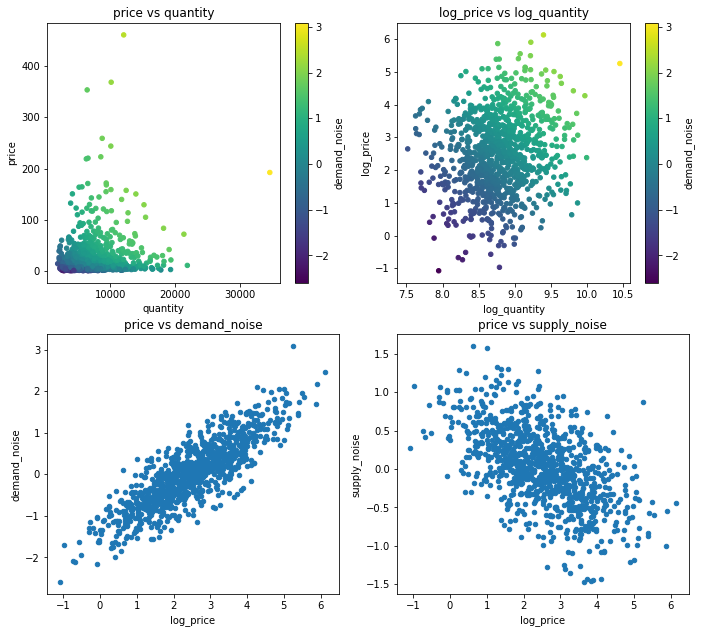

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(11.5,10.5))

df.plot.scatter(x='quantity',
                y='price',
                c='demand_noise',
                colormap='viridis',
                ax=ax[0,0],
                title='price vs quantity');

df.plot.scatter(x='log_quantity',
                y='log_price',
                c='demand_noise',
                colormap='viridis',
                ax=ax[0,1],
                title='log_price vs log_quantity');
                
df.plot.scatter(x='log_price',
                y='demand_noise',
                ax=ax[1,0],
                title='price vs demand_noise');

df.plot.scatter(x='log_price',
                y='supply_noise',
                ax=ax[1,1],
                title='price vs supply_noise');



### Regression

In [6]:
print('beta_d = {}\nbeta_s = {}'.format(*beta_list))

beta_d = -0.5
beta_s = 0.3


In [7]:
## True model
result = sm.ols(formula="log_quantity ~ log_price + demand_noise", data=df).fit(cov_type='HC1',use_t=True)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_quantity   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.614e+30
Date:                Mon, 01 Aug 2022   Prob (F-statistic):               0.00
Time:                        07:07:02   Log-Likelihood:                 31129.
No. Observations:                1000   AIC:                        -6.225e+04
Df Residuals:                     997   BIC:                        -6.224e+04
Df Model:                           2                                         
Covariance Type:                  HC1                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.0000   8.98e-16   1.11e+16      0.000      10.000      10.000
log_price       -0.5000   3.77e-16  -1.33e+15      0.000      -0.500      -0.500
demand_noise     1.0000   5.65e-16   1.77e+15      0.000       1.000       1.000
==============================================================================
Omnibus:                        0.094   Durbin-Watson:                   0.107
Prob(Omnibus):                  0.954   Jarque-Bera (JB):                0.133
Skew:                           0.021   Prob(JB):                        0.936
Kurtosis:                       2.962   Cond. No.                         14.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [8]:
## naive model
result = sm.ols(formula="log_quantity ~ log_price", data=df).fit(cov_type='HC1',use_t=True)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_quantity   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     33.61
Date:                Mon, 01 Aug 2022   Prob (F-statistic):           9.01e-09
Time:                        07:07:02   Log-Likelihood:                -533.82
No. Observations:                1000   AIC:                             1072.
Df Residuals:                     998   BIC:                             1081.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.6213      0.029    295.872      0.000       8.564       8.678
log_price      0.0633      0.011      5.798      0.000       0.042       0.085
==============================================================================
Omnibus:                        3.897   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.142   Jarque-Bera (JB):                4.510
Skew:                           0.020   Prob(JB):                        0.105
Kurtosis:                       3.326   Cond. No.                         7.07
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [9]:
weighted_beta = np.inner(np.array(beta_list), np.array([theta, 1-theta]))
print(weighted_beta)

0.07528089887640449


### Coeficient Distribution

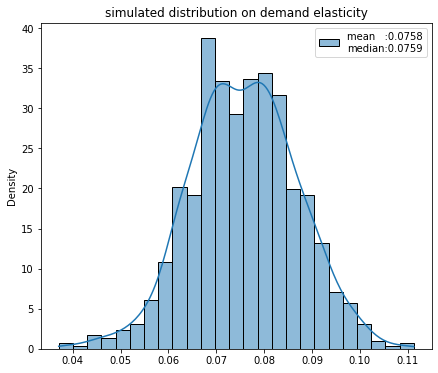

In [10]:
simulation_cnt = 1000
coef_list = []

for i in range(simulation_cnt):
    Marketgenerator_tmp = DataGenerator()
    df_tmp = Marketgenerator_tmp.get_data()[0]
    res = sm.ols(formula="log_quantity ~ log_price", data=df_tmp).fit(cov_type='HC1',use_t=True)
    coef_list.append(res.params[1])

### plot the distribution
fig, ax = plt.subplots(figsize=(7, 6))
sns.histplot(x=coef_list, kde=True,stat='density',ax=ax, label='mean   :{:.4f}\nmedian:{:.4f}'.format(np.mean(coef_list),np.median(coef_list)))
plt.title("simulated distribution on demand elasticity")
plt.legend();